# Generating the Mercator grid for 1/4 degree ocean

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Mercator projection


For a given $(longitude,latitude) = (\lambda, \phi)$ the isotropic Mercator projection can be written as:  
$$\begin{equation}
y = M(\phi) = R \ln \left[ 1+\sin\phi \over \cos\phi \right].  
\end{equation}$$
The corresponding inverse function can be written as:
$$\begin{equation}
\phi = M^{-1}(y) = \tan^{-1}\left(\sinh(y/R)\right).
\end{equation}$$

Here $R$ is called the representative fraction (RF) or the principal scale of the projection (in units of the radius of the (isotropic) Earth $a_E$). E.g., to project the earth surface to a rectangular map of width $L$ one can use a principal scale of $L/(2\pi a_{E})$ (which corresponds to a "globe" of radius $L/2\pi$.)

These are one of a few equivalent analytic forms of the projection function. For an overview and more information refer to [https://en.wikipedia.org/wiki/Mercator_projection](the wikipedia).


# Defining a Mercator grid


We want to generate an isotropic Mercator grid corresponding to a 1/4 degree resolution at the equator. Here are the defining parameters of our super-grid:

 
1. The (super)grid cell resolution in longitude direction $\Delta \lambda = {1/8}^\circ $.  
2. The (super)grid cell resolution in latitude  direction shall be the same as in longitude direction at the equator $\Delta \phi(\phi=0) = \Delta \lambda$. 

So:
  
1. To achieve 1. above we partition the equator to $N_i$ intervals. The condition 1. above fixes $N_i=2880$ , since  $\Delta \lambda = (1/8)(\pi/180) = {2\pi\over N_i}$.
2. To achieve 2. above we need to calculate $\Delta y$ given $\Delta \phi$:
$$\begin{equation*}
\Delta \phi = \Delta y \left. ({d\phi \over dy}) \right|_{y=0} = \Delta y {1\over R} {\cosh(y/R) \over 1+\sinh^2(y/R)} |_{y=0} = {\Delta y \over R}
\end{equation*}$$

Now 1. and 2. fix the value of the projection scale $R$ as follows:
$$\begin{equation}
R = {\Delta y \over \Delta \phi}|_{y=0} = {\Delta y \over \Delta \lambda}|_{y=0} = {1 \over (\delta \lambda /N_i)} = {N_i \over 2\pi}
\end{equation}$$


Note that we treat $y$ as an index in the latitude direction $\Delta y = \Delta j =1 $!


## Specification via approximate latitude bounds

If we are given $N_i$, $\tilde{\Phi}_s$, $\tilde{\Phi}_n$ then:
\begin{align}
R &= \frac{N_i}{2\pi} \\
y_s &= {int} (\tilde{\Phi}_s) \\
y_n &= {int} (\tilde{\Phi}_n)
\end{align}
and
\begin{align}
\Phi_s &= \Phi(y_s) \\
\Phi_n &= \Phi(y_n)
\end{align}
where $\Phi_s \neq \tilde{\Phi}_s$ and $\Phi_n \neq \tilde{\Phi}_n$

#### How should $\tilde{\Phi}_s$ and $\tilde{\Phi}_n$ be specified?

In [70]:
#Grid Specifications
# Specify the desired resolution
degree_resolution_inverse = 4 #quarter degree grid
# Specify the grid properties
refine=2      # Set to 2 for supergrid
lat0_M=-65.0  # This is a nominal starting latitude for Mercator grid
lon0_M=-300.  # Starting longitude
lenlat_M=125 # nominal latitude range of Mercator grid
lenlon_M=360 
# Specify approximate latitude range
#phi_s, phi_n = lat0_M,lat0_M+lenlat_M
# To reproduce MIDAS we need to change these to the values produced by MIDAS 
phi_s, phi_n = -66.85954724706843, 64.0589597296948
# Calculate ni,nj
N_i=lenlon_M*refine*degree_resolution_inverse
N_j=700*refine

#Constants
PI_180 = np.pi/180.
Re = 6.378e6

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [100]:
def y_mercator(Ni, phi):
    """Equation (1)"""
    R = Ni / (2 * np.pi)
    return R * ( np.log( (1.0 + np.sin(phi) ) / np.cos(phi)) )
def phi_mercator(Ni, y):
    """Equation (2)"""
    R = Ni / (2 * np.pi)
    return np.arctan( np.sinh(y/R) ) * (180/np.pi) # Converted to degrees
def y_mercator_rounded(Ni, phi):
    y_float = y_mercator(Ni, phi)
    return ( np.sign(y_float) * np.ceil( np.abs(y_float) ) ).astype(int)

def generate_mercator_grid(Ni,Nj,phi_s,phi_n,lon0_M,lenlon_M):
    # Diagnose nearest integer y(phi range)
    y_star = y_mercator_rounded(Ni, np.array([phi_s*PI_180,phi_n*PI_180]))
    print( 'y*=',y_star, 'nj=', y_star[1]-y_star[0] )
    print( 'Actual phi range: phi_s,phi_n=', phi_mercator(Ni, y_star) )
    phi_M = phi_mercator(Ni, np.arange(y_star[0],y_star[1]+1)) 
    print( 'Grid =', phi_M )
    if(y_star[1]-y_star[0] != Nj):
        print("Error: the Mercator construct did not produce the expected number of j points ",Nj)
    y_grid_M = np.tile(phi_M.reshape(Nj+1,1),(1,Ni+1))
    lam_M = lon0_M + np.arange(Ni+1) * lenlon_M/Ni
    x_grid_M = np.tile(lam_M,(Nj+1,1)) 
    return x_grid_M,y_grid_M
    

def mdist(x1,x2):
  """Returns positive distance modulo 360."""
  a=np.mod(x1-x2+720.,360.)
  b=np.mod(x2-x1+720.,360.)
  d=np.minimum(a,b)
  return d

def generate_grid_metrics(x,y,axis_units='degrees'):
    nytot,nxtot = x.shape
    if  axis_units == 'm':
      metric=1.0
    if  axis_units == 'km':            
      metric=1.e3
    if  axis_units == 'degrees':                        
      metric=Re*PI_180
    ymid_j = 0.5*(y+np.roll(y,shift=-1,axis=0))
    ymid_i = 0.5*(y+np.roll(y,shift=-1,axis=1))      
    dy_j = np.roll(y,shift=-1,axis=0) - y
    dy_i = np.roll(y,shift=-1,axis=1) - y
    dx_i = mdist(np.roll(x,shift=-1,axis=1),x)
    dx_j = mdist(np.roll(x,shift=-1,axis=0),x)
    dx = metric*metric*(dy_i*dy_i + dx_i*dx_i*np.cos(ymid_i*PI_180)*np.cos(ymid_i*PI_180))
    dx = np.sqrt(dx)
    dy = metric*metric*(dy_j*dy_j + dx_j*dx_j*np.cos(ymid_j*PI_180)*np.cos(ymid_j*PI_180))
    dy = np.sqrt(dy)
    dx=dx[:,:-1]
    dy=dy[:-1,:]
    area=dx[:-1,:]*dy[:,:-1]    
    angle_dx=np.zeros((nytot,nxtot))
    angle_dx = np.arctan2(dy_i,dx_i)/PI_180      
    return dx,dy,area,angle_dx


def write_nc(x,y,dx,dy,area,angle,axis_units='degrees',fnam=None,format='NETCDF3_CLASSIC'):
    import netCDF4 as nc

    if fnam is None:
      fnam='supergrid.nc'
    f=nc.Dataset(fnam,'w',format=format)
    dims=[]
    vars=[]
    nytot,nxtot = y.shape
    nyp=f.createDimension('nyp',nytot)
    nxp=f.createDimension('nxp',nxtot)
    ny=f.createDimension('ny',nytot-1)
    nx=f.createDimension('nx',nxtot-1)    
    yv=f.createVariable('y','f8',('nyp','nxp'))
    xv=f.createVariable('x','f8',('nyp','nxp'))    
    yv.units=axis_units
    xv.units=axis_units 
    yv[:]=y
    xv[:]=x
    dyv=f.createVariable('dy','f8',('ny','nxp'))
    dyv.units='meters'
    dyv[:]=dy
    dxv=f.createVariable('dx','f8',('nyp','nx'))
    dxv.units='meters'
    dxv[:]=dx
    areav=f.createVariable('area','f8',('ny','nx'))
    areav.units='m2'
    areav[:]=area
    anglev=f.createVariable('angle_dx','f8',('nyp','nxp'))
    anglev.units='degrees'
    anglev[:]=angle            
    f.sync()
    f.close()

#generate the grid
lamM,phiM = generate_mercator_grid(N_i,N_j,phi_s,phi_n,lon0_M,lenlon_M)    
#### Why N_j comes out of the above but is needed as an input to MIDAS?

#generate the metrics
dxM,dyM,areaM,angleM = generate_grid_metrics(lamM,phiM,axis_units='degrees')

#write the grid file
write_nc(lamM,phiM,dxM,dyM,areaM,angleM,axis_units='degrees',fnam='mercator_new.nc')

y*= [-727  673] nj= 1400
Actual phi range: phi_s,phi_n= [-66.85954725  64.05895973]
Grid = [-66.85954725 -66.81037464 -66.76110332 ...  63.94938346  64.00422531
  64.05895973]


# Generating a Mercator grid via package MIDAS

The code snippet below uses the MIDAS package to generate the Mercator grid. We first want to study the calls in this package to find out how MIDAS has been generating the grids. Note that this "import"s a class that was isolated from original MIDAS, hence we call it "pymidas" to distinguish it from the whole package. This is a small fraction of MIDAS and is pure Python.

Note: I am generating this notebook with anaconda Python 3 on my workstation. 

First let's take a look at the grid generated straight from pymidas for a given longitude (since the grid is homogeneous in x direction).

In [101]:
from pymidas.rectgrid_gen import supergrid
#### Begin Mercator Grid
print ('constructing a mercator supergrid with (ni,nj) = ',N_i,N_j)
print ('nominal starting lat and starting longitude =',lat0_M, lon0_M)
print ('and nominal width in latitude = ',lenlat_M)
mercator=supergrid(nxtot=N_i,xstart=lon0_M,lenx=lenlon_M,
                   nytot=N_j,ystart=lat0_M,leny=lenlat_M,
                   config='mercator',axis_units='degrees',cyclic_x=True)
mercator.grid_metrics()
mercator.write_nc('mercator_supergrid.nc')
print ("mercator start/end latitudes=",mercator.y[0,0],mercator.y[-1,0])
print ("mercator start/end longitude=",mercator.x[0,0],mercator.x[0,-1])

constructing a mercator supergrid with (ni,nj) =  2880 1400
nominal starting lat and starting longitude = -65.0 -300.0
and nominal width in latitude =  125
mercator start/end latitudes= -66.85954724706843 64.0589597296948
mercator start/end longitude= -300.0 60.0


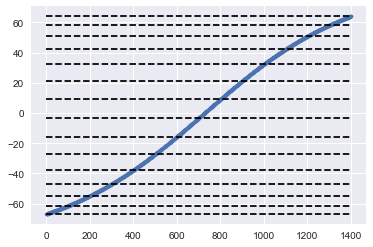

In [102]:
plt.plot( mercator.y[:,0], '.');
for j in np.arange(0,N_j+1,100):
    plt.plot([0,1400],[mercator.y[j,0],mercator.y[j,0]],linestyle='dashed',color='black')

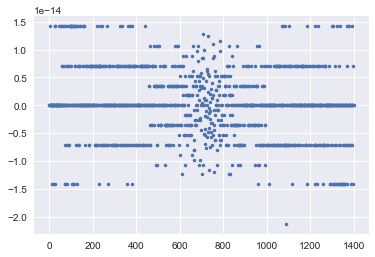

In [104]:
plt.plot( mercator.y[:,0] - phiM[:,0], '.');

# Southern Ocean spherical grid

## Simple line

In [116]:
nj_SO=110*refine
lat0_SO=-78.0
lenlat_SO = phiM.min()-lat0_SO 

def generate_latlon_grid(lni,lnj,llon0,llen_lon,llat0,llen_lat):
    llonSP = llon0 + np.arange(lni+1) * llen_lon/lni
    llatSP = llat0 + np.arange(lnj+1) * llen_lat/lnj
    llamSP = np.tile(llonSP,(lni+1,1)) 
    lphiSP = np.tile(llatSP.reshape((lnj+1,1)),(1,lni+1)) 
    return llamSP,lphiSP

lamSO,phiSO = generate_latlon_grid(N_i,nj_SO,lon0_M,lenlon_M,lat0_SO,lenlat_SO)


## MIDAS

In [117]:
from pymidas.rectgrid_gen import supergrid

#### Begin Spherical Grid for Southern Ocean
print ('constructing a spherical supergrid with (ny,nx) = ',nj_SO,N_i)
spherical=supergrid(N_i,nj_SO,'spherical','degrees',lat0_SO,mercator.y.min()-lat0_SO,lon0_M,lenlon_M,cyclic_x=True)
spherical.grid_metrics()
spherical.write_nc('antarctic_spherical_supergrid.nc')
print ("antarctic spherical max/min latitude=", spherical.y.max(),spherical.y.min())
print ("spherical nj,ni=", spherical.y.shape[0]-1,spherical.y.shape[1]-1)
print ("spherical starting longitude=",spherical.x[0,0])
print ("spherical ending longitude=",spherical.x[0,-1])


constructing a spherical supergrid with (ny,nx) =  220 2880
antarctic spherical max/min latitude= -66.85954724706843 -78.0
spherical nj,ni= 220 2880
spherical starting longitude= -300.0
spherical ending longitude= 60.0


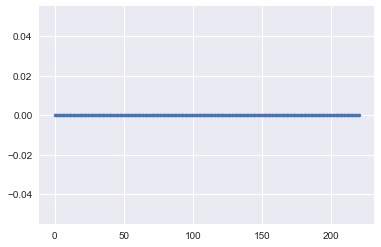

In [119]:
plt.plot( spherical.y[:,0]-phiSO[:,0], '.');

Note the difference is due to the difference between our formula generated starting latitude of Mercator grid grid_y_mercator[0] and MIDAS generated quantity mercator.y[0,0]

end lattude of SouthernSP -64.00422531295267
start lattude of Mercator -64.00422531295267


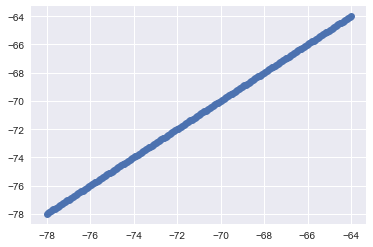

In [11]:
lenlat_sp = mercator.y.min()-lat0_sp #Should replace mercator.y.min with the formula
geo_lat=np.zeros(ny2+ny+3)

for j in np.arange(ny2+1):
    geo_lat[j] = lat0_sp + j * lenlat_sp/ny2

for j in np.arange(1,ny+3):
    geo_lat[ny2+j] = geo_lat[ny2] + j * lenlat/ny

print("end lattude of SouthernSP", grid_y_sp[-1])    
print("start lattude of Mercator", mercator.y[0,0])    

plt.plot(geo_lat[:ny2+1], grid_y_sp[:], 'o');
#plt.plot(geo_lat[ny2+2:], mercator.y[:,0], '.');



#plt.plot(geo_lat, mercator.y[:,0], '.');
#plt.plot(geo_lat[:ny2+1], spherical.y[:,0], '.');
#plt.plot(geo_lat[ny2+2:], mercator.y[:,0], '.');

# Tripolar grid

Definitions and constructing formulas for a bipolar grid from Murray's 1996 paper (R.J. Murray, Explicit Generation of Orthogonal Grids for Ocean Models, Journal of Computational Physics 126, 251-273 (1996))

Points on the grid sphere 

$\lambda_c$ and $\phi_c$ are the longitude and latitude of the point X on the spherical grid.

$\lambda_s$ and $\phi_s$ are the longitude and latitude of the point X on the projected-re-projected bipolar grid.

$\Phi_P$    is the latitude of the bounding parallel of bipolar grid (tripolar N cap).

$\lambda_0$ is the longitude of the rotated (bipolar) equator (longitude of the displaced pole).

## MIDAS

In [453]:
refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125
lat0=-65.0 # This is a nominal starting latitude for Mercator grid
lon0=-300. # Starting longitude
lenlat=125. # nominal latitude range of Mercator grid
lenlon=360. 
nx=1440*refine
ny=700*refine

ny_ncap=119*refine
lat0_tp=mercator.y.max()
dlat=90.0-lat0_tp
tripolar_n=supergrid(nx,ny_ncap,'spherical','degrees',lat0_tp,dlat,lon0,360.,tripolar_n=True)
tripolar_n.grid_metrics()
tripolar_n.write_nc('ncap_supergrid.nc')
print ("generated a tripolar supergrid of size (ny,nx)= ",tripolar_n.y.shape[0]-1,tripolar_n.y.shape[1]-1)
print ("tripolar grid starting longitude = ",tripolar_n.x[0,0])
print ("tripolar grid starting latitude = ",tripolar_n.y[0,0])
print (np.shape(tripolar_n.x) , np.shape(tripolar_n.y))

generated a tripolar supergrid of size (ny,nx)=  238 2880
tripolar grid starting longitude =  -300.0
tripolar grid starting latitude =  61.24769287161847
(239, 2881) (239, 2881)


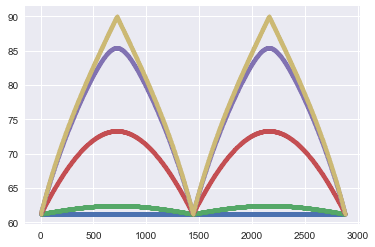

In [454]:
plt.plot( tripolar_n.y[0,:], '.');
plt.plot( tripolar_n.y[10,:], '.');
plt.plot( tripolar_n.y[100,:], '.');
plt.plot( tripolar_n.y[200,:], '.');
plt.plot( tripolar_n.y[238,:], '.');

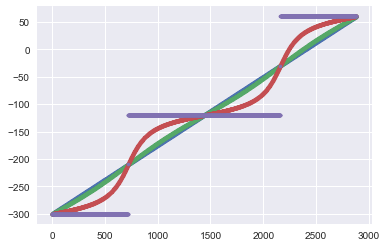

In [455]:
plt.plot( tripolar_n.x[1,:], '.');
plt.plot( tripolar_n.x[100,:], '.');
plt.plot( tripolar_n.x[200,:], '.');
plt.plot( tripolar_n.x[238,:], '.');


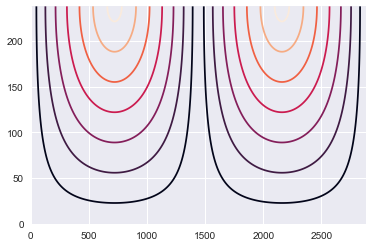

In [456]:
plt.contour(tripolar_n.y)

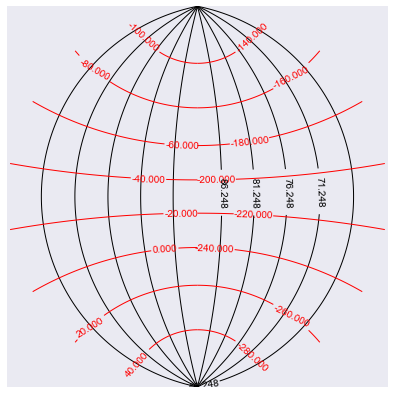

In [493]:
plot_grid(tripolar_n.x, tripolar_n.y, sp_grid_x,sp_grid_y,lon0,lat0_tp,dlon=5)

In [464]:
def plot_grid0(sp_grid_x,sp_grid_y,lon0=0):

    from mpl_toolkits.basemap import Basemap
    import matplotlib
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,7))
    # You can set negative contours to be solid instead of dashed:
    matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    map = Basemap(projection='stere',lon_0=lon0,lat_0=0,resolution='l')

    x,y = map(sp_grid_x,sp_grid_y)

    #print(np.shape(x), np.shape(y)) #(239, 2881) (239, 2881)

    cs_x = map.contour(x,y,sp_grid_y,colors='k',linewidths=1.0)
    cs_y = map.contour(x,y,sp_grid_x,colors='k',linewidths=1.0)

    #map.drawcoastlines()   




In [24]:
def plot_grid_stere(lon_grid,lat_grid, grid_x,grid_y,lon0=0,coastline=False):

    from mpl_toolkits.basemap import Basemap
    import matplotlib
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,7))
    # You can set negative contours to be solid instead of dashed:
    matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    map = Basemap(projection='stere',lat_0=0,lon_0=lon0,resolution='l',
                  llcrnrlon=lon0-20, llcrnrlat=-50, urcrnrlon=lon0+20, urcrnrlat=50)

    mx,my = map(lon_grid,lat_grid)

    #print(np.shape(x), np.shape(y)) #(239, 2881) (239, 2881)

    cs_x = map.contour(mx,my, grid_y,colors='k',linewidths=1.0)
    cs_y = map.contour(mx,my, grid_x,colors='r',linewidths=1.0, levels=np.linspace(lon0, lon0+360, 20))
    plt.clabel(cs_y, inline=1, fontsize=10)
    if(coastline) :
        map.drawcoastlines()   




In [467]:
def plot_grid(lon_grid,lat_grid, grid_x,grid_y,lon0=0,lat0=0,dlon=20,dlat=20,coastline=False):

    from mpl_toolkits.basemap import Basemap
    import matplotlib
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,7))
    # You can set negative contours to be solid instead of dashed:
    matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    map = Basemap(projection='npstere',boundinglat=lat0,lon_0=lon0,resolution='l')

    mx,my = map(lon_grid,lat_grid)

    #print(np.shape(x), np.shape(y)) #(239, 2881) (239, 2881)

    cs_x = map.contour(mx,my, grid_y,colors='k',linewidths=1.0, levels=np.arange(lat0, 90, dlon))
#    cs_y = map.contour(mx,my, grid_x,colors='r',linewidths=1.0, levels=np.linspace(lon0, lon0+360, 20))
    cs_y = map.contour(mx,my, grid_x,colors='r',linewidths=1.0, levels=np.arange(lon0, lon0+360, dlat))
    plt.clabel(cs_y, inline=1, fontsize=10)
    plt.clabel(cs_x, inline=1, fontsize=10)
    if(coastline) :
        map.drawcoastlines()   




\lambda_c and \phi_c are longitude and latitude of the point X on the spherical grid.
\lambda_s and \phi_s are longitude and latitude of the point X on the projected-re-projected dipolar grid.
\Phi_P the latitude of the bounding parallel of tripolar cap.
\lambda_0 is the longitude of the rotated (bipolar) equator (longitude of the displaced pole).

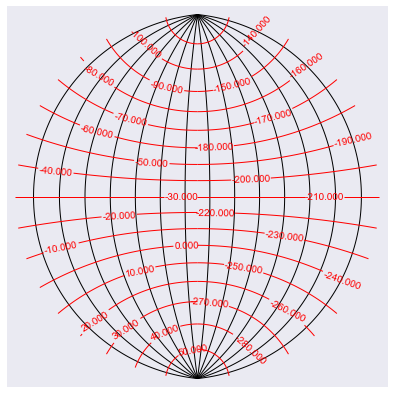

In [108]:
refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125
nxtot=1440*refine
nytot=119*refine
lon0=-300.   # Starting longitude, this will be the longitude of the  bi-pole(s)
lenx=360. 
lat0=mercator.y.max()
leny=90.0-lat0
#Spherical grid 
jindp=np.arange(nytot+1);iindp=np.arange(nxtot+1)        
sp_y=lat0+jindp*leny/nytot  #array([61.24769287, 61.36850088, ..., 89.87919199, 90.  ])
sp_x=lon0+iindp*lenx/nxtot 
sp_grid_x = np.tile(sp_x,(nytot+1,1)) #(239, 2881)
sp_grid_y = np.tile(sp_y.reshape((nytot+1,1)),(1,nxtot+1)) #(239, 2881)

def mdist(x1,x2):
  """Returns positive distance modulo 360."""
  a=np.mod(x1-x2+720.,360.)
  b=np.mod(x2-x1+720.,360.)
  d=np.minimum(a,b)
  return d

rp=np.tan(0.5*(0.5*np.pi - (sp_grid_y[0])*PI_180)) #Murray section 2.2 before Eq(6) r_p=tan(\phi_P\prime /2) 
                                                   #where \phi_P is the latitude of the bounding parrallel lat0
##MIDAS lon,lat=self.tp_trans():
##MIDAS lamc=self.bp_lon() #Why is this lon?
chi=2.0*np.arctan(np.tan(0.5*(0.5*np.pi-sp_grid_y*PI_180))/rp) #Murray Inverse of Eq(5b) 
#lamc = 0.5*np.pi - chi  #Why??????????
#lamc[:,:(nxtot//2)] = lamc[:,:(nxtot//2)] - np.pi/2
#lamc[:,(nxtot//2):] =-lamc[:,(nxtot//2):] + np.pi/2
#OR equivalently
lamc = - chi  #Why??????????
lamc[:,:(nxtot//2)] =  lamc[:,:(nxtot//2)] 
lamc[:,(nxtot//2):] =- lamc[:,(nxtot//2):] 
##phic=self.bp_colat() #Why is this co-lat in  MIDAS?
phic=mdist(sp_grid_x,lon0) *PI_180
##phic=(sp_grid_x-lon0) *PI_180 
chic =np.arccos(np.sin(phic)*np.cos(lamc))    #Murray Eq(6) assuming phic is 90-phic !! ***********??
#chic =np.arccos(np.cos(phic)*np.cos(lamc))    #Murray Eq(6) the grid does not make sense !!
tp_grid_y = 90 - np.arctan(rp*np.tan(chic/2.0)) * 2/PI_180 #Murray Eq(5b) for \phi_s
tp_grid_x = np.arctan(np.tan(phic)*np.sin(lamc)) /PI_180   #Murray part of Eq(5a)  assuming phic is 90-phic !!
#The following gymnastics in Midas is missing from Murray paper. 
#Does this accomplish 90-atan(sin(\lambda_c)tan(\phi_c))?
tp_grid_x[:,:nxtot//4]=-tp_grid_x[:,:nxtot//4]
tp_grid_x[:,nxtot//4]=90.0
tp_grid_x[:,nxtot//4+1:nxtot//2]=180.0-tp_grid_x[:,nxtot//4+1:nxtot//2]
tp_grid_x[:,nxtot//2]=180.
tp_grid_x[:,nxtot//2+1:3*nxtot//4]=180.0-tp_grid_x[:,nxtot//2+1:3*nxtot//4]
tp_grid_x[:,3*nxtot//4]=270.
tp_grid_x[:,3*nxtot//4+1:]=360.-tp_grid_x[:,3*nxtot//4+1:]
tp_grid_x = tp_grid_x + lon0 #Murray part of Eq(5a)  

plot_grid( tp_grid_x,tp_grid_y, sp_grid_x,sp_grid_y,lon0)

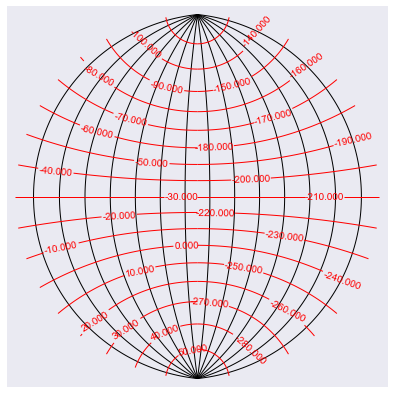

In [111]:
plot_grid(tripolar_n.x, tripolar_n.y, sp_grid_x,sp_grid_y,lon0)

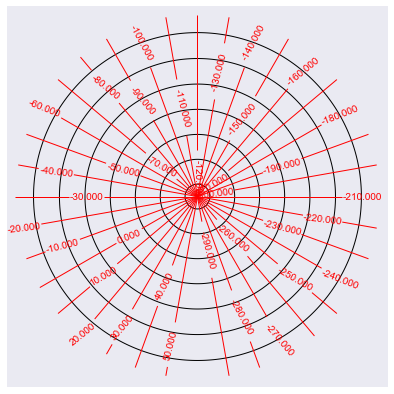

In [37]:
plot_grid(sp_grid_x,sp_grid_y, sp_grid_x,sp_grid_y,lon0)

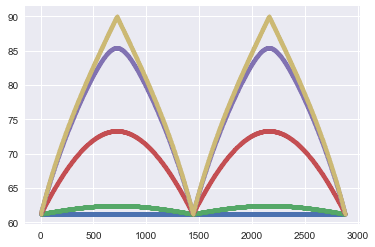

In [109]:
plt.plot( tp_grid_y[0,:], '.');
plt.plot( tp_grid_y[10,:], '.');
plt.plot( tp_grid_y[100,:], '.');
plt.plot( tp_grid_y[200,:], '.');
plt.plot( tp_grid_y[238,:], '.');

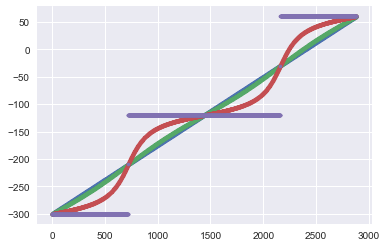

In [110]:
plt.plot( tp_grid_x[1,:], '.');
plt.plot( tp_grid_x[100,:], '.');
plt.plot( tp_grid_x[200,:], '.');
plt.plot( tp_grid_x[238,:], '.');


In [226]:
def atan2(x,y):
    angle = np.arctan( x / y )
    angle2 = np.where( x>0, angle+np.pi, angle-np.pi )
    return np.where( y>0, angle, angle2)

In [270]:
refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125
nxtot=1440*refine
nytot=119*refine
lon0=-300.   # Starting longitude, this will be the longitude of the  bi-pole(s)
lenx=360. 
lat0=mercator.y.max()
leny=90.0-lat0
#Spherical grid 
#lenx=90.
#nxtot = nxtot//4

jindp=np.arange(nytot+1);iindp=np.arange(nxtot+1)        
sp_y=lat0+jindp*leny/nytot  #array([61.24769287, 61.36850088, ..., 89.87919199, 90.  ])
sp_x=lon0+iindp*lenx/nxtot
sp_grid_x = np.tile(sp_x,(nytot+1,1)) #(239, 2881)
print("sp_grid_x.shape",sp_grid_x.shape)
sp_grid_y = np.tile(sp_y.reshape((nytot+1,1)),(1,nxtot+1)) #(239, 2881)
print("sp_grid_y.shape",sp_grid_y.shape)

sp_grid_x.shape (239, 2881)
sp_grid_y.shape (239, 2881)


A great circle is the intersection of the sphere with a plane through the origin. Let a unit normal to that plane be u=[−sin(γ),0,cos(γ)]u=[−sin⁡(γ),0,cos⁡(γ)], where for convenience we choose our xx and yy axes so that u2=0u2=0. Then in spherical coordinates, the equation u⋅[sin(ϕ)cosθ),sin(ϕ)sin(θ),cos(ϕ)]=0u⋅[sin⁡(ϕ)cos⁡θ),sin⁡(ϕ)sin⁡(θ),cos⁡(ϕ)]=0 becomes cot(ϕ)=tan(γ)cos(θ)cot⁡(ϕ)=tan⁡(γ)cos⁡(θ). Rotating around the zz axis, this becomes cot(ϕ)=tan(γ)cos(θ−θ0)cot⁡(ϕ)=tan⁡(γ)cos⁡(θ−θ0).




@MISC {247336,
    TITLE = {Clairaut&#39;s relation and the equation of great circle in spherical coordinates},
    AUTHOR = {Robert Israel (https://mathoverflow.net/users/13650/robert-israel)},
    HOWPUBLISHED = {MathOverflow},
    NOTE = {URL:https://mathoverflow.net/q/247336 (version: 2016-08-12)},
    EPRINT = {https://mathoverflow.net/q/247336},
    URL = {https://mathoverflow.net/q/247336}
}
       
\bib\{247336}{misc}{    
    title={Clairaut&#39;s relation and the equation of great circle in spherical coordinates},    
    author={Robert Israel (https://mathoverflow.net/users/13650/robert-israel)},    
    note={URL: https://mathoverflow.net/q/247336 (version: 2016-08-12)},    
    eprint={https://mathoverflow.net/q/247336},    
    organization={MathOverflow}  
}       

In [332]:
#Project hemisphere onto plane tangent at equator at lon00
refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125

#define a (lon,lat) spherical coordinate on the whole globe
nxtot0=1440*refine
nytot0=1440 *refine
lon00=0.
lenx0=360. 
lat00=-90.
leny0=180.

sp_lon0 = lon00 + np.arange(nxtot0+1) * lenx0/nxtot0
sp_lat0 = lat00 + np.arange(nytot0+1) * leny0/nytot0

sp_lon0_tile = np.tile(sp_lon0,(nytot0+1,1)) 
sp_lat0_tile = np.tile(sp_lat0.reshape((nytot0+1,1)),(1,nxtot0+1)) 
print("sp_lon0_tile.shape",sp_lon0_tile.shape) #(1441, 1441)
print("sp_lat0_tile.shape",sp_lat0_tile.shape) #(1441, 1441)

sp_lon0_tile.shape (2881, 2881)
sp_lat0_tile.shape (2881, 2881)


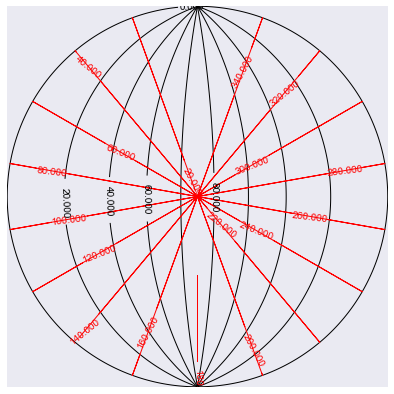

In [370]:
#Equations of the great circles with and axis passing through the equator at longitude lon_p (and lon_p+180)
lon_p = 0

lam = sp_lon0_tile
phi = sp_lat0_tile

lamc = lam - 180  #-180 is totally heuristic, to make constistent with the parrallels in the next cell
phic = np.arctan( np.tan(phi *PI_180) * np.cos((lam-lon_p-90)*PI_180)) /PI_180
phic = np.abs(phic)

plot_grid(lamc,phic , sp_lon0_tile,sp_lat0_tile);

/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in arccos


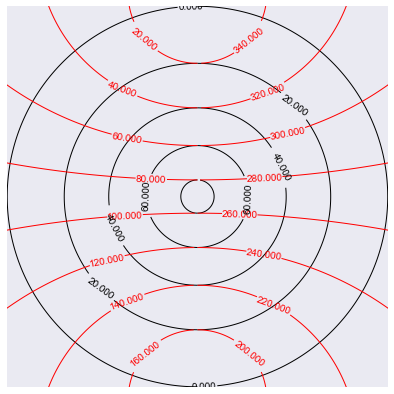

In [366]:
#Equations of the parallels with axis passing through the equator at longitude lon_p (and lon_p+180)
lon_p = 0
epsilon = 0.0001

lam = sp_lon0_tile
phi = sp_lat0_tile

lamc = lon_p + np.sign(lam-epsilon-180) * np.arccos(np.sin((lam-lon_p-90)*PI_180)/np.cos(phi*PI_180)) /PI_180
phic = phi

plot_grid(lamc,phic , sp_lon0_tile,sp_lat0_tile);

/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply
/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


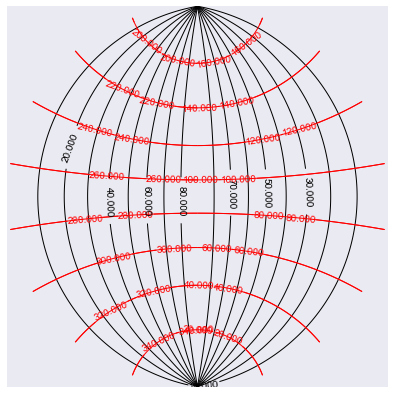

In [516]:
#Now let's combine the two Equations
lon_p = 0
lam = sp_lon0_tile
phi = sp_lat0_tile
alpha = np.sin((lam-lon_p-90)*PI_180)
beta  = 1/np.tan(phi*PI_180)
A=np.sqrt((1-alpha**2)/(1+beta**2)) 
B=np.sqrt(beta**2 * (1-alpha**2)/(alpha**2+beta**2))  #Actually two equations  +- |B|
phic = np.arcsin(A)/PI_180 
lamc = np.arcsin(B)/PI_180 
#But this equation accepts 4 solutions for a given B, {l, 180-l, l+180, 360-l } 
#We have to pickup the "correct" root. 
#One way is simply to demand lamc to be continous with lam on the equator phi=0
#I am sure there is a more mathematically concrete way to do this.
lamc = np.where((sp_lon0>90)&(sp_lon0<=180),180-lamc,lamc)
lamc = np.where((sp_lon0>180)&(sp_lon0<=270),180+lamc,lamc)
lamc = np.where((sp_lon0>270),360-lamc,lamc)

lamc = lamc + lon_p

plot_grid(lamc,phic , sp_lon0_tile,sp_lat0_tile,lon0=lon_p, lat0=0, dlon=10);

/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


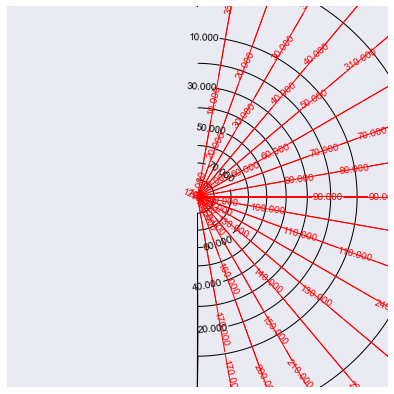

In [518]:
#Invert    
lams = 90+lon_p+np.arcsin(np.cos(phic*PI_180) * np.cos((lamc-lon_p)*PI_180))/PI_180
phis = np.arctan(np.tan(phic*PI_180)/np.sin((lamc-lon_p)*PI_180))/PI_180


plot_grid(lams, phis, lam,phi, lon0=lon_p, lat0=0,dlat=10,dlon=10);

61.247692871618455


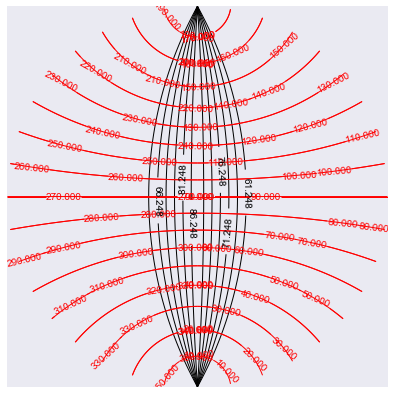

In [548]:
#Project back onto the larger (true) sphere so that the projected equator shrinks to latitude \phi_P=lat0_tp
#then we have tan(\phi_s'/2)=tan(\phi_p'/2)tan(\phi_c'/2)
print(lat0_tp)
rp=np.tan(0.5*(90-lat0_tp)*PI_180)
phis = 90 - 2 * np.arctan(rp * np.tan(0.5*(90-phic)*PI_180))/PI_180
lams = lamc
plot_grid(lams, phis, lam,phi, lon0=lon_p, lat0=lat0_tp, dlat=10, dlon=5);

In [567]:
refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125
nxtot=1440*refine
nytot=119*refine
lon0=-300.   # Starting longitude, this will be the longitude of the  bi-pole(s)
lenx=360. 
lat0=mercator.y.max()
leny=90.0-lat0
#Spherical grid 
jindp=np.arange(nytot+1);iindp=np.arange(nxtot+1)        
sp_y=lat0+jindp*leny/nytot  #array([61.24769287, 61.36850088, ..., 89.87919199, 90.  ])
sp_x=lon0+iindp*lenx/nxtot 
sp_grid_x = np.tile(sp_x,(nytot+1,1)) #(239, 2881)
sp_grid_y = np.tile(sp_y.reshape((nytot+1,1)),(1,nxtot+1)) #(239, 2881)


sp_lon0_tile.shape (239, 2881)
sp_lat0_tile.shape (239, 2881)


/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in true_divide
/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in multiply
/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide


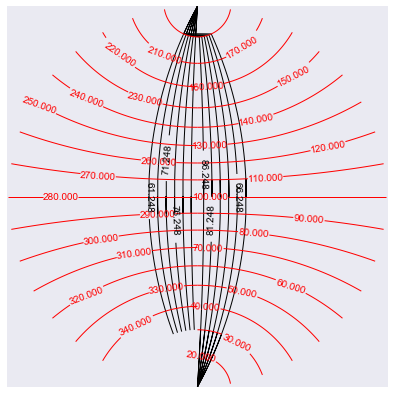

In [582]:
#We should have chosen the resolution of the phi grid correctly:
#Project hemisphere onto plane tangent at equator at lon00
refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125

#nxtot=1440*refine
#nytot=119*refine
#lon0=-300.   # Starting longitude, this will be the longitude of the  bi-pole(s)
#lenx=360. 
#lat0=mercator.y.max()
#leny=90.0-lat0

#define a (lon,lat) spherical coordinate on the whole globe
nxtot0=1440*refine
nytot0=119*refine
#nytot0=1440 *refine
lon00=0.       
lenx0=360. 
lat00=0.
leny0=90.
lon_p = 10  #Does not work for anything other than 0!
sp_lon0 = lon00 + np.arange(nxtot0+1) * lenx0/nxtot0 
sp_lat0 = lat00 + np.arange(nytot0+1) * leny0/nytot0

sp_lon0_tile = np.tile(sp_lon0,(nytot0+1,1)) 
sp_lat0_tile = np.tile(sp_lat0.reshape((nytot0+1,1)),(1,nxtot0+1)) 
print("sp_lon0_tile.shape",sp_lon0_tile.shape) #(1441, 1441)
print("sp_lat0_tile.shape",sp_lat0_tile.shape) #(1441, 1441)lon_p = 0
lam = sp_lon0_tile
phi = sp_lat0_tile
alpha = np.sin((lam-lon_p-90)*PI_180)
beta  = 1/np.tan(phi*PI_180)
A=np.sqrt((1-alpha**2)/(1+beta**2)) 
B=np.sqrt(beta**2 * (1-alpha**2)/(alpha**2+beta**2))  #Actually two equations  +- |B|
phic = np.arcsin(A)/PI_180 
lamc = np.arcsin(B)/PI_180 
#But this equation accepts 4 solutions for a given B, {l, 180-l, l+180, 360-l } 
#We have to pickup the "correct" root. 
#One way is simply to demand lamc to be continous with lam on the equator phi=0
#I am sure there is a more mathematically concrete way to do this.
lamc = np.where((sp_lon0>90)&(sp_lon0<=180),180-lamc,lamc)
lamc = np.where((sp_lon0>180)&(sp_lon0<=270),180+lamc,lamc)
lamc = np.where((sp_lon0>270),360-lamc,lamc)
lamc = lamc + lon_p
#Project back onto the larger (true) sphere so that the projected equator shrinks to latitude \phi_P=lat0_tp
#then we have tan(\phi_s'/2)=tan(\phi_p'/2)tan(\phi_c'/2)
rp=np.tan(0.5*(90-lat0_tp)*PI_180)
phis = 90 - 2 * np.arctan(rp * np.tan(0.5*(90-phic)*PI_180))/PI_180
lams = lamc

plot_grid(lams, phis, lam,phi, lon0=lon_p, lat0=lat0_tp, dlat=10, dlon=5);

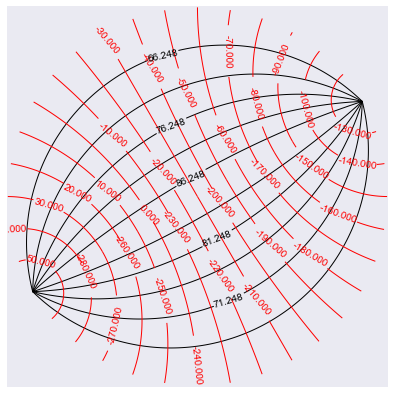

In [575]:
plot_grid(lams,phis, sp_grid_x,sp_grid_y,lon0=lon0,lat0=lat0_tp, dlat=10,dlon=5);

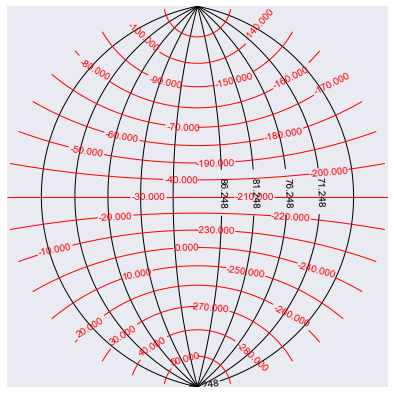

In [561]:
plot_grid(tripolar_n.x, tripolar_n.y, sp_grid_x,sp_grid_y,lon0=lon0,lat0=lat0_tp, dlat=10,dlon=5)

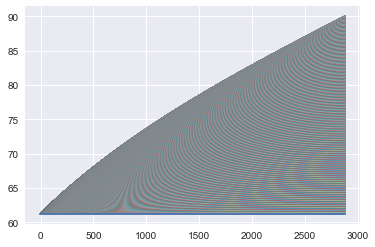

In [572]:
plt.plot(phis);

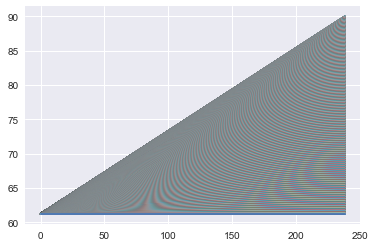

In [557]:
plt.plot(tripolar_n.y);

/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in arcsin
/net2/nnz/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in arccos


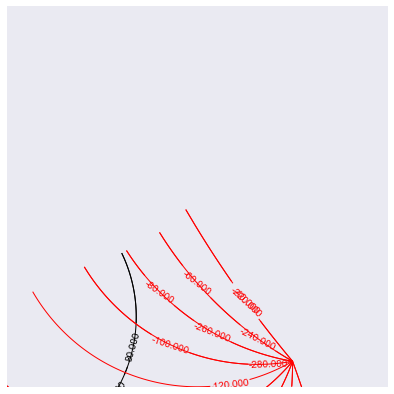

In [349]:
rp=np.tan(0.5*(90 - sp_grid_y[0,0])*PI_180) #Murray section 2.2 before Eq(6) r_p=tan(\phi_P\prime /2) 
                                                   #where \phi_P is the latitude of the bounding parrallel lat0

chi_c=2.0*np.arctan(np.tan(0.5*(90-sp_grid_y)*PI_180)/rp) #Murray Inverse of Eq(5b) 

A = np.cos(chi_c)
B = np.tan((lon0+90-sp_grid_x)*PI_180)

phi_c = np.arcsin(A/B)
lam_c = np.arccos(A/np.cos(phi_c)) #A/np.sqrt(1-(A/B)**2) 

tp_grid_x = lam_c / PI_180
tp_grid_y = phi_c / PI_180

#tp_grid_y[:,:(nxtot//2)] =  tp_grid_y[:,:(nxtot//2)] 
#tp_grid_y[:,(nxtot//2):] =- tp_grid_y[:,(nxtot//2):] 

#tp_grid_x[:,:nxtot//4]=-tp_grid_x[:,:nxtot//4]
#tp_grid_x[:,nxtot//4+1:nxtot//2]=180.0-tp_grid_x[:,nxtot//4+1:nxtot//2]
#tp_grid_x[:,nxtot//2+1:3*nxtot//4]=180.0-tp_grid_x[:,nxtot//2+1:3*nxtot//4]
#tp_grid_x[:,3*nxtot//4+1:]=360.-tp_grid_x[:,3*nxtot//4+1:]

plot_grid( tp_grid_x,tp_grid_y, sp_grid_x,sp_grid_y,lon0);

0.2563127715053832 61.247692871618455 90.0 61.247692871618455


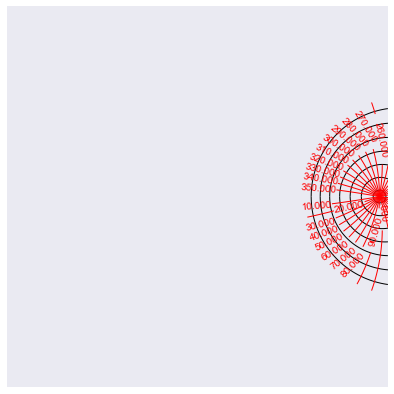

In [252]:
def atan2(x,y):
    angle = np.arctan( x / y )
    angle2 = np.where( x>0, angle+np.pi, angle-np.pi )
    return np.where( y>0, angle, angle2)
jindp=np.arange(nytot+1);iindp=np.arange(nxtot+1)        
sp_y=lat0+jindp*leny/nytot  #array([61.24769287, 61.36850088, ..., 89.87919199, 90.  ])
sp_x=0*lon0+iindp*lenx/nxtot
lambda_c = np.tile(sp_x,(nytot+1,1)) #(239, 2881)
phi_c = np.tile(sp_y.reshape((nytot+1,1)),(1,nxtot+1)) #(239, 2881)
rp=np.tan(0.5*(0.5*np.pi - phi_c[0,0]*PI_180)) #Murray section 2.2 before Eq(6) r_p=tan(\phi_P\prime /2) 
                                                   #where \phi_P is the latitude of the bounding parrallel lat0
chi_c =np.arccos(np.cos(phi_c*PI_180)*np.cos(lambda_c*PI_180))    #Murray Eq(6) the grid does not make sense !!

phi_s = 90 - np.arctan(rp*np.tan(chi_c/2.0)) * 2/PI_180 #Murray Eq(5b) for \phi_s
lambda_s = lon0*0 + 90 - atan2( np.sin(lambda_c*PI_180), np.tan(phi_c*PI_180) ) /PI_180   #Murray part of Eq(5a)  assuming phic is 90-phic !!
print(rp, phi_c.min(), phi_c.max(), phi_c[0,0])

plot_grid(lambda_s, phi_s, lambda_c, phi_c);

0.2563127715053832 61.247692871618455 90.0 61.247692871618455


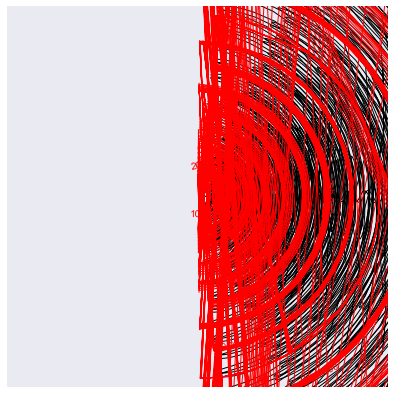

In [256]:
def atan2(x,y):
    angle = np.arctan( x / y )
    angle2 = np.where( x>0, angle+np.pi, angle-np.pi )
    return np.where( y>0, angle, angle2)
jindp=np.arange(nytot+1);iindp=np.arange(nxtot+1)        
sp_y=lat0+jindp*leny/nytot  #array([61.24769287, 61.36850088, ..., 89.87919199, 90.  ])
sp_x=0*lon0+iindp*lenx/nxtot
lam_s = np.tile(sp_x,(nytot+1,1)) #(239, 2881)
phi_s = np.tile(sp_y.reshape((nytot+1,1)),(1,nxtot+1)) #(239, 2881)

rp=np.tan(0.5*(0.5*np.pi - phi_s[0,0]*PI_180)) #Murray section 2.2 before Eq(6) r_p=tan(\phi_P\prime /2) 
                                                   #where \phi_P is the latitude of the bounding parrallel lat0
#chi_c =np.arccos(np.cos(phi_c*PI_180)*np.cos(lambda_c*PI_180))    #Murray Eq(6) the grid does not make sense !!
chi_c =np.arccos(np.sin(phi_c*PI_180)*np.cos(lambda_c*PI_180))    #Murray Eq(6) the grid does not make sense !!

phi_s = 90 - np.arctan(rp*np.tan(chi_c/2.0)) * 2/PI_180 #Murray Eq(5b) for \phi_s
lambda_s = lon0*0 + 90 - np.arctan(np.tan(phi_c)*np.sin(lambda_c)) /PI_180   #Murray part of Eq(5a)  assuming phic is 90-phic !!
print(rp, phi_c.min(), phi_c.max(), phi_c[0,0])

plot_grid(lambda_s, phi_s, lambda_c, phi_c);

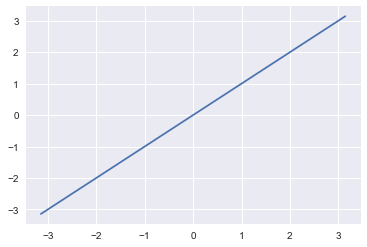

In [205]:
def atan2(x,y):
    angle = np.arctan( x / y )
    angle2 = np.where( x>0, angle+np.pi, angle-np.pi )
    return np.where( y>0, angle, angle2)
angle = np.linspace(-np.pi, np.pi, 100)
x = np.sin( angle )
y = np.cos( angle )
plt.plot(angle,  atan2(x,y) )

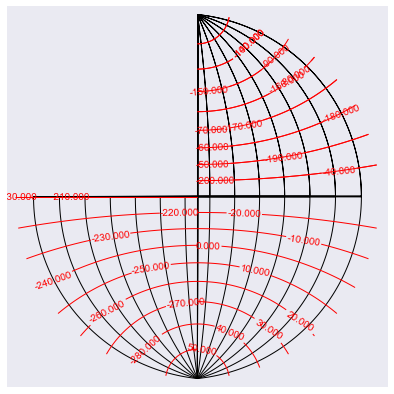

In [269]:
refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125
nxtot=1440*refine
nytot=119*refine
lon0=-300.   # Starting longitude, this will be the longitude of the  bi-pole(s)
lenx=360. 
lat0=mercator.y.max()
leny=90.0-lat0
#Spherical grid 
jindp=np.arange(nytot+1);iindp=np.arange(nxtot+1)        
sp_y=lat0+jindp*leny/nytot  #array([61.24769287, 61.36850088, ..., 89.87919199, 90.  ])
sp_x=lon0+iindp*lenx/nxtot 
sp_grid_x = np.tile(sp_x,(nytot+1,1)) #(239, 2881)
sp_grid_y = np.tile(sp_y.reshape((nytot+1,1)),(1,nxtot+1)) #(239, 2881)

def mdist(x1,x2):
  """Returns positive distance modulo 360."""
  a=np.mod(x1-x2+720.,360.)
  b=np.mod(x2-x1+720.,360.)
  d=np.minimum(a,b)
  return d

def atan2(x,y):
    angle = np.arctan( x / y )
    angle2 = np.where( x>0, angle+np.pi, angle-np.pi )
    return np.where( y>0, angle, angle2)

rp=np.tan(0.5*(0.5*np.pi - (sp_grid_y[0])*PI_180)) #Murray section 2.2 before Eq(6) r_p=tan(\phi_P\prime /2) 
                                                   #where \phi_P is the latitude of the bounding parrallel lat0
##MIDAS lon,lat=self.tp_trans():
##MIDAS lamc=self.bp_lon() #Why is this lon?
chi=2.0*np.arctan(np.tan(0.5*(0.5*np.pi-sp_grid_y*PI_180))/rp) #Murray Inverse of Eq(5b) 
#lamc = 0.5*np.pi - chi  #Why??????????
#lamc[:,:(nxtot//2)] = lamc[:,:(nxtot//2)] - np.pi/2
#lamc[:,(nxtot//2):] =-lamc[:,(nxtot//2):] + np.pi/2
#OR equivalently
lamc = - chi  #Why??????????
#lamc[:,:(nxtot//2)] =  lamc[:,:(nxtot//2)] 
#lamc[:,(nxtot//2):] =- lamc[:,(nxtot//2):] 
##phic=self.bp_colat() #Why is this co-lat in  MIDAS?
phic=mdist(sp_grid_x,lon0) *PI_180
##phic=(sp_grid_x-lon0) *PI_180 
chic =np.arccos(np.sin(phic)*np.cos(lamc))    #Murray Eq(6) assuming phic is 90-phic !! ***********??
#chic =np.arccos(np.cos(phic)*np.cos(lamc))    #Murray Eq(6) the grid does not make sense !!
tp_grid_y = 90 - np.arctan(rp*np.tan(chic/2.0)) * 2/PI_180 #Murray Eq(5b) for \phi_s

#tp_grid_x = atan2( np.sin(lamc), np.tan(0.5*np.pi-phic) ) /PI_180   #Murray part of Eq(5a)  assuming phic is 90-phic !!
tp_grid_x = np.arctan(np.tan(phic)*np.sin(lamc)) /PI_180   #Murray part of Eq(5a)  assuming phic is 90-phic !!
#The following gymnastics in Midas is missing from Murray paper. 
#Does this accomplish 90-atan(sin(\lambda_c)tan(\phi_c))?
#tp_grid_x[:,:nxtot//4]=-tp_grid_x[:,:nxtot//4]
#tp_grid_x[:,nxtot//4]=90.0
tp_grid_x[:,nxtot//4+1:nxtot//2]=180.0-tp_grid_x[:,nxtot//4+1:nxtot//2]
#tp_grid_x[:,nxtot//2]=180.
tp_grid_x[:,nxtot//2+1:3*nxtot//4]=180.0-tp_grid_x[:,nxtot//2+1:3*nxtot//4]
#tp_grid_x[:,3*nxtot//4]=270.
tp_grid_x[:,3*nxtot//4+1:]=360.-tp_grid_x[:,3*nxtot//4+1:]
tp_grid_x = tp_grid_x + lon0 #Murray part of Eq(5a)  

plot_grid( tp_grid_x,tp_grid_y, sp_grid_x,sp_grid_y,lon0)